<a href="https://www.kaggle.com/code/ainurrohmanbwx/sentiment-analysis-using-bert-on-commodity-news?scriptVersionId=123809710" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Abstrak

This experiment explores the use of sentiment analysis using BERT on news articles related to the gold commodity market. The goal of this experiment was to gain insights into the sentiment surrounding the gold market and to determine the effectiveness of BERT in analyzing sentiment in financial news articles. Our experiment achieved an accuracy of 86.1% in classifying sentiment in the news articles, which is a commendable result and demonstrates the effectiveness of BERT in this context. By accurately classifying sentiment, we can provide valuable insights to investors, traders, and analysts in the industry, which can aid in making informed decisions. The potential applications of sentiment analysis using BERT are vast, and this study highlights the potential of this technique in the analysis of financial markets and other industries where sentiment plays a critical role. The results of this study suggest that sentiment analysis using BERT can be a valuable tool in extracting subjective information from text data, such as opinions, emotions, and attitudes.

# Introduction

Sentiment analysis is a powerful technique in natural language processing that allows us to extract subjective information from text data, such as opinions, emotions, and attitudes. In recent years, with the rise of deep learning models, sentiment analysis has become increasingly accurate and efficient. One such model is BERT (Bidirectional Encoder Representations from Transformers), a state-of-the-art language model developed by Google.

In this experiment, we will apply sentiment analysis using BERT on news articles related to the gold commodity market. Gold is a precious metal that has been used for centuries as a store of value, and its price is often seen as a barometer of global economic and political uncertainty. By analyzing sentiment in news articles, we can gain insights into how the market perceives gold at a particular time, and how this sentiment may affect its price. This experiment has the potential to provide valuable information for investors, traders, and analysts who are interested in the gold market.

# Literature review

BERT (Bidirectional Encoder Representations from Transformers) is a pre-trained language model developed by Google that has significantly improved the performance of natural language processing (NLP) tasks such as language understanding, sentiment analysis, and text classification. Here are some of the pros and cons of BERT:

Pros:

* Improved NLP Performance: BERT has achieved state-of-the-art results on many NLP benchmarks, outperforming other models.

* Generalizable: BERT has been pre-trained on a massive amount of data, which enables it to capture the context and meaning of text more accurately. This makes it highly generalizable to a wide range of NLP tasks.

* Transfer Learning: BERT can be fine-tuned on smaller, task-specific datasets to further improve its performance. This means that it can be used for a wide range of applications without requiring extensive data or resources.

* Multilingual: BERT has been trained on text from multiple languages, making it useful for NLP tasks across a wide range of languages.

* Open-Source: BERT is an open-source project, meaning that researchers and developers can access the source code and modify it for their needs.

Cons:

* Resource-Intensive: BERT requires significant computational resources, including high-end GPUs, to train and fine-tune. This can make it difficult for researchers and developers without access to these resources to use BERT.

* Large Model Size: BERT has a large model size, which can make it challenging to deploy in resource-constrained environments such as mobile devices.

* Lack of Transparency: The inner workings of BERT are complex, making it difficult to understand how it works and how it makes decisions. This can make it challenging to diagnose and fix issues when they arise.

* Limited Interpretability: BERT produces high-quality predictions, but the process it uses to arrive at these predictions is often opaque. This can make it difficult to interpret the results and understand how they were generated.

# Experiment

## Resouce Check

In [36]:
!nvidia-smi

Wed Mar 29 09:54:30 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    35W /  70W |  11168MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

In [37]:
import torch

if torch.cuda.is_available():
  device = torch.device('cuda')

  print('there are %d GPU(s) available.' % torch.cuda.device_count())

  print('we will use the GPU: ', torch.cuda.get_device_name(0))

else:
  print("No GPU available, using the CPU instead")
  device = torch.device("cpu")

there are 2 GPU(s) available.
we will use the GPU:  Tesla T4


## Install Library

In [38]:
!pip install contractions

import warnings
warnings.filterwarnings('ignore')

## Load Data

In [39]:
import pandas as pd

df = pd.read_csv('/kaggle/input/sentiment-analysis-in-commodity-market-gold/gold-dataset-sinha-khandait.csv', usecols=["Price Sentiment", "News"])
df.rename(columns = {'News':'news', 'Price Sentiment':'sentiment'}, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10570 entries, 0 to 10569
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   news       10570 non-null  object
 1   sentiment  10570 non-null  object
dtypes: object(2)
memory usage: 165.3+ KB


## Exploratory data analysis

In [40]:
df = df[(df.sentiment != "none")]
df = df.replace({'sentiment' : {'negative':0, 'neutral':1, 'positive':2}})
df.head()

,news,sentiment
0,"april gold down 20 cents to settle at $1,116.1...",0
1,gold suffers third straight daily decline,0
2,Gold futures edge up after two-session decline,2
4,"Gold snaps three-day rally as Trump, lawmakers...",0
5,"Dec. gold climbs $9.40, or 0.7%, to settle at ...",2


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8602 entries, 0 to 10569
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   news       8602 non-null   object
 1   sentiment  8602 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 201.6+ KB


### Sentiment distribution

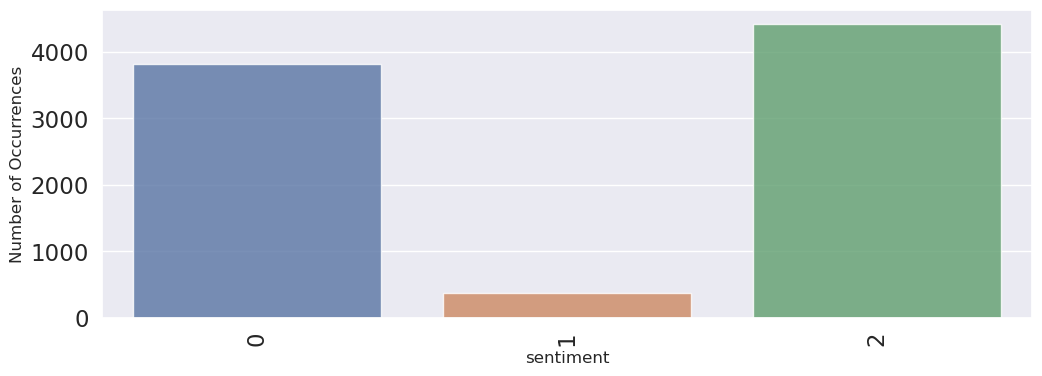

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

sentiment = df['sentiment'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(x=sentiment.index, y=sentiment.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('sentiment', fontsize=12)
plt.xticks(rotation=90)
plt.show();

## Data preparation

### Data cleaning

In [43]:
from bs4 import BeautifulSoup

def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  [s.extract() for s in soup(['iframe', 'script'])]
  stripped_text = soup.get_text()
  stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
  return stripped_text

def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

def stopwords_removal(words):
    list_stopwords = nltk.corpus.stopwords.words('english')
    return [word for word in words if word not in list_stopwords]

In [44]:
import re
import nltk
import tqdm
import unicodedata
import contractions

from nltk.tokenize import word_tokenize

def pre_process_corpus(docs):
  norm_docs = []
  for doc in tqdm.tqdm(docs):
    #case folding
    doc = doc.lower()
    #remove special characters\whitespaces
    doc = strip_html_tags(doc)
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = remove_accented_chars(doc)
    doc = contractions.fix(doc)
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()
    #tokenize
    doc = word_tokenize(doc)
    #filtering
    doc = stopwords_removal(doc)
    norm_docs.append(doc)
  
  norm_docs = [" ".join(word) for word in norm_docs]
  return norm_docs

In [45]:
%%time
df.news = pre_process_corpus(df.news)

100%|██████████| 8602/8602 [00:04<00:00, 2130.45it/s]


CPU times: user 3.83 s, sys: 224 ms, total: 4.05 s
Wall time: 4.05 s


In [46]:
df.head()

,news,sentiment
0,april gold 20 cents settle 111610oz,0
1,gold suffers third straight daily decline,0
2,gold futures edge twosession decline,2
4,gold snaps threeday rally trump lawmakers reac...,0
5,december gold climbs 940 07 settle 135690oz,2


### Load BERT Tokenizer

In [47]:
sentences = df.news.values
labels = df.sentiment.values

In [48]:
from transformers import BertTokenizer

print("load BERT Tokenizer")
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased', do_lower_cased = True)

load BERT Tokenizer


In [49]:
print('Original:', sentences[0])
print('Tokenized:', tokenizer.tokenize(sentences[0]))
print('Token IDS:', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

Original: april gold 20 cents settle 111610oz
Tokenized: ['april', 'gold', '20', 'cents', 'settle', '111', '##6', '##10', '##oz']
Token IDS: [10636, 12888, 10200, 54696, 75156, 15734, 11325, 20216, 19615]


In [50]:
input_ids = []
for sent in sentences:
    encoded_sent = tokenizer.encode(sent, add_special_tokens = True)
    input_ids.append(encoded_sent)
    
print('Original:', sentences[0])
print('Token IDS:', input_ids[0])

Original: april gold 20 cents settle 111610oz
Token IDS: [101, 10636, 12888, 10200, 54696, 75156, 15734, 11325, 20216, 19615, 102]


In [51]:
print('Max Sentence length', max([len(sen) for sen in input_ids]))

Max Sentence length 25


In [52]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_LEN = 256

print('padding/truncating all sentences to %d values' % MAX_LEN)
print('padding token:"{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype='long', value=0, truncating='post', padding='post')

print('Done')

padding/truncating all sentences to 256 values
padding token:"[PAD]", ID: 0
Done


In [53]:
input_ids[0]

array([  101, 10636, 12888, 10200, 54696, 75156, 15734, 11325, 20216,
       19615,   102,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [54]:
attention_mask = []

for sent in input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]
    
    attention_mask.append(att_mask)

### Data splitting

In [55]:
from sklearn.model_selection import train_test_split

train_input, test_input, train_labels, test_labels = train_test_split(input_ids, labels, random_state=42, test_size=0.1)
train_mask, test_mask, _, _ = train_test_split(attention_mask, labels, random_state=42, test_size=0.1)

train_input, validation_input, train_labels, validation_labels = train_test_split(train_input, train_labels, random_state=42, test_size=0.1)
train_mask, validation_mask, _, _ = train_test_split(train_mask, train_mask, random_state=42, test_size=0.1)

In [56]:
import numpy as np

print('---Train---')
print('input: ', train_input.shape)
print('label: ', train_labels.shape)
print('mask: ', np.array(train_mask).shape)

print('---Validation---')
print('input: ', validation_input.shape)
print('label: ', validation_labels.shape)
print('mask: ', np.array(validation_mask).shape)

print('---Test---')
print('input: ', test_input.shape)
print('label: ', test_labels.shape)
print('mask: ', np.array(test_mask).shape)

---Train---
input:  (6966, 256)
label:  (6966,)
mask:  (6966, 256)
---Validation---
input:  (775, 256)
label:  (775,)
mask:  (775, 256)
---Test---
input:  (861, 256)
label:  (861,)
mask:  (861, 256)


In [57]:
train_input = torch.tensor(train_input)
train_labels = torch.tensor(train_labels)
train_mask = torch.tensor(train_mask)

validation_input = torch.tensor(validation_input)
validation_labels = torch.tensor(validation_labels)
validation_mask = torch.tensor(validation_mask)

test_input = torch.tensor(test_input)
test_labels = torch.tensor(test_labels)
test_mask = torch.tensor(test_mask)

In [58]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_data = TensorDataset(train_input, train_mask, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_input, validation_mask, validation_labels)
validation_sampler = RandomSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

test_data = TensorDataset(test_input, test_mask, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

## Modelling

### Model Pre-Trained BERT

In [59]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-uncased", num_labels = 3, output_attentions = False, output_hidden_states = False)
model.cuda()

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [60]:
params = list(model.named_parameters())

print("The BERT model has {:} different named parameters.".format(len(params)))

print("==== Embedding Layer ====")
for p in params[0:5]:
  print("{:<60} {:>12}".format(p[0], str(tuple(p[1].size()))))

print("==== First Transformers ====")
for p in params[5:21]:
  print("{:<60} {:>12}".format(p[0], str(tuple(p[1].size()))))

print("==== Output Layer ====")
for p in params[-4:]:
  print("{:<60} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.
==== Embedding Layer ====
bert.embeddings.word_embeddings.weight                       (105879, 768)
bert.embeddings.position_embeddings.weight                     (512, 768)
bert.embeddings.token_type_embeddings.weight                     (2, 768)
bert.embeddings.LayerNorm.weight                                   (768,)
bert.embeddings.LayerNorm.bias                                     (768,)
==== First Transformers ====
bert.encoder.layer.0.attention.self.query.weight               (768, 768)
bert.encoder.layer.0.attention.self.query.bias                     (768,)
bert.encoder.layer.0.attention.self.key.weight                 (768, 768)
bert.encoder.layer.0.attention.self.key.bias                       (768,)
bert.encoder.layer.0.attention.self.value.weight               (768, 768)
bert.encoder.layer.0.attention.self.value.bias                     (768,)
bert.encoder.layer.0.attention.output.dense.weight             (768, 768)
bert.

In [61]:
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8 )

In [62]:
from transformers import get_linear_schedule_with_warmup

epochs = 5

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

In [63]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [64]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

### Training BERT

In [65]:
import time
import random
import datetime

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

loss_values = []

for epoch_i in range(0, epochs):

  # ===================================
  #              Training
  # ===================================

  print("======= Epoch {:} / {:} =======".format(epoch_i+1, epochs))
  print("Training...")

  t0 = time.time()

  total_loss = 0

  model.train()

  # For each batch of training data
  for step, batch in enumerate(train_dataloader):
    
    # Progress update every 40 batches
    if step % 40 == 0 and not step == 0:
      elapsed = format_time(time.time() - t0)

      print("Batch {:>5,} of {:>5,}.     Elapsed: {:}".format(step, len(train_dataloader), elapsed))
    
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    model.zero_grad()

    outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels)
    
    loss = outputs[0]

    total_loss += loss.item()

    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optimizer.step()

    scheduler.step()

  avg_train_loss = total_loss / len(train_dataloader)

  loss_values.append(avg_train_loss)

  print("   Average training loss: {0:.2f}".format(avg_train_loss))
  print("   Training epoch took: {:}".format(format_time(time.time() - t0)))

  # ===================================
  #             Validation
  # ===================================

  print("Running Validation...")

  t0 = time.time()

  model.eval()

  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  for batch in validation_dataloader:

    batch = tuple(t.to(device) for t in batch)

    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
      outputs = model(b_input_ids,
                      token_type_ids=None,
                      attention_mask=b_input_mask)
    
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)

    eval_accuracy += tmp_eval_accuracy

    nb_eval_steps += 1
  
  print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
  print("Validation took: {:}".format(format_time(time.time() - t0)))

print("Training complete!")

======= Epoch 1 / 5 =======
Training...
Batch    40 of   218.     Elapsed: 0:00:55
Batch    80 of   218.     Elapsed: 0:01:49
Batch   120 of   218.     Elapsed: 0:02:42
Batch   160 of   218.     Elapsed: 0:03:36
Batch   200 of   218.     Elapsed: 0:04:30
   Average training loss: 0.64
   Training epoch took: 0:04:54
Running Validation...
Accuracy: 0.81
Validation took: 0:00:13
======= Epoch 2 / 5 =======
Training...
Batch    40 of   218.     Elapsed: 0:00:54
Batch    80 of   218.     Elapsed: 0:01:48
Batch   120 of   218.     Elapsed: 0:02:42
Batch   160 of   218.     Elapsed: 0:03:36
Batch   200 of   218.     Elapsed: 0:04:29
   Average training loss: 0.36
   Training epoch took: 0:04:53
Running Validation...
Accuracy: 0.85
Validation took: 0:00:13
======= Epoch 3 / 5 =======
Training...
Batch    40 of   218.     Elapsed: 0:00:54
Batch    80 of   218.     Elapsed: 0:01:48
Batch   120 of   218.     Elapsed: 0:02:42
Batch   160 of   218.     Elapsed: 0:03:35
Batch   200 of   218.     El

## Evaluation

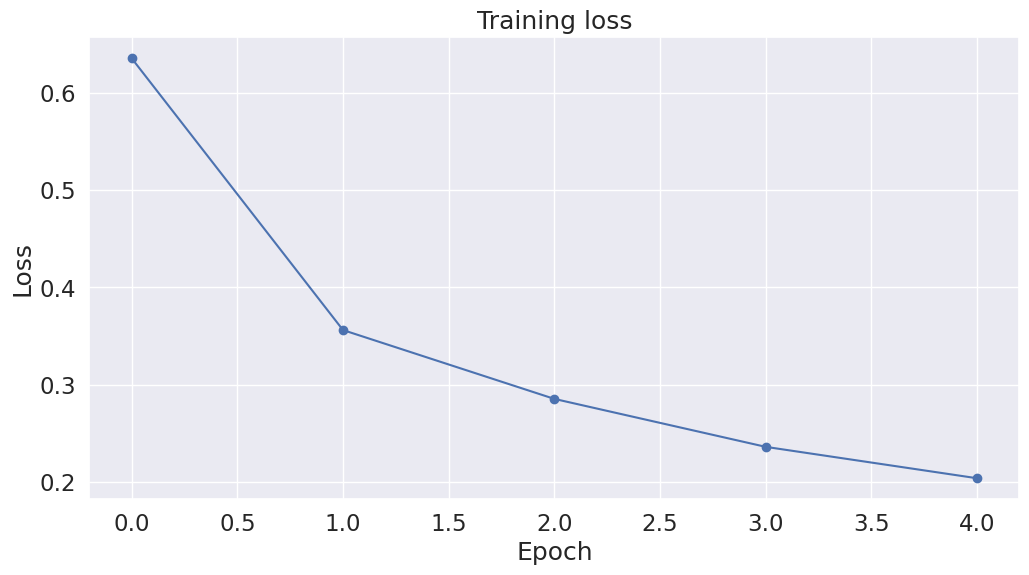

In [66]:
%matplotlib inline

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(loss_values, 'b-o')

plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [67]:
print("Predicting labels for {:,} test sentences".format(len(test_input)))

model.eval()

prediction, true_labels = [], []

for batch in test_dataloader:
  batch = tuple(t.to(device) for t in batch)

  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
    outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask)
    
  logits = outputs[0]

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  prediction.append(logits)
  true_labels.append(label_ids)

print(" DONE.")

Predicting labels for 861 test sentences
 DONE.


In [68]:
from sklearn.metrics import matthews_corrcoef

# evaluation for data imbalance
flat_prediction = [item for sublist in prediction for item in sublist]
flat_prediction = np.argmax(flat_prediction, axis=1).flatten()

flat_true_labels = [item for sublist in true_labels for item in sublist]

mcc = matthews_corrcoef(flat_true_labels, flat_prediction)

print("MCC: %.3f" %mcc)

MCC: 0.735


In [69]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(flat_true_labels, flat_prediction)

print("ACC: %.3f" %acc)

ACC: 0.861


# Result

In our sentiment analysis experiment using BERT on gold commodity news, we achieved an accuracy of 86.1%. While this may not be as high as some other models or experiments, it is still a commendable result and demonstrates the effectiveness of BERT in analyzing sentiment in financial news articles.

Through this experiment, we have gained valuable insights into the sentiment surrounding the gold commodity market, which can be useful for investors, traders, and analysts in making informed decisions. The potential applications of sentiment analysis using BERT are vast, and we believe that this technique has the potential to be a valuable tool in various industries, from finance to healthcare, and beyond.

# Conclusion

The results of our experiment demonstrate the effectiveness of using BERT for sentiment analysis on news articles related to the gold commodity market. While this study was focused on the gold market, the potential applications of sentiment analysis using BERT are vast and extend to other industries and contexts.

One area where implementing BERT could be particularly valuable is in social media monitoring. By analyzing sentiment in social media posts, companies can gain insights into how their customers perceive their brand, products, and services. This information can be used to improve customer satisfaction and loyalty, as well as inform marketing and product development strategies.

Additionally, implementing BERT on other platforms, such as chatbots or virtual assistants, could enhance their ability to understand and respond to natural language. This could lead to more personalized and efficient interactions, improving customer satisfaction and overall user experience.

In conclusion, the potential applications of sentiment analysis using BERT are vast, and this study highlights the potential of this technique in the analysis of financial markets and beyond. As the use of natural language processing and machine learning continues to grow, we anticipate that sentiment analysis using BERT will become increasingly valuable in various industries and contexts.